# Conceptual Design

### Demo 2D structure

Exploration of use of Python/Jupyter to analyze and visualize structures discussed in Hervé Capart's _Conceptual Design_ class at NTU Civil Engineering.

# Preliminaries

In [1]:
import os
import numpy as np
import sympy as sy
from sympy import init_printing
init_printing(use_unicode=True, pretty_print=True, wrap_line=True)
from cdsn.mesh import Mesh
from cdsn.graph import Graph
from cdsn.communities import Communities
from cdsn.geometry import Geometry
from cdsn.forces import Forces
from cdsn.plot import Visualization
from cdsn.save import create_directories, export_plots

# Geometry

In [2]:
name = "simpleStructure1"
# name = "standingTower1"

In [3]:
mesh = Mesh(name)
mesh.file_path_name, mesh.trimesh

('../Data/STL/simpleStructure1.stl',
 <trimesh.Trimesh(vertices.shape=(18, 3), faces.shape=(14, 3))>)

In [4]:
graph = Graph(mesh)
graph.nxgraph, graph.n_triangles

(<networkx.classes.graph.Graph at 0x16d754b80>, 14)

In [5]:
communities = Communities(graph)
communities.n_communities, #communities.d_community_nodes

In [6]:
geometry = Geometry(communities)

In [7]:
geometry.d_keynode_appliedload

{7: 0}

In [8]:
geometry.d_member_appliedloads

# Forces

In [9]:
forces = Forces(geometry)

In [10]:
from sympy import (
    Eq, Symbol, MatrixSymbol, MatAdd, Matrix, Rational, Integer,
)

Write matrix equations for each member.

Need to specify force vector components at each keynode. Do this symbolically. Then write a vector for all force components for all keynodes of each member.

First build dictionary of vector components at all keynodes.

In [11]:
d_keynode_fvc = {
    keynode_: {
        "X": Symbol(rf"F_{keynode_},X", real=True,),
        "Y": Symbol(rf"F_{keynode_},Y", real=True,),
    }
    for keynode_ in geometry.d_keynode_members
}
[(fvc_["X"],fvc_["Y"]) for fvc_ in d_keynode_fvc.values()]
[[Integer(keynode_)]+[fvc_ for fvc_ in d_keynode_fvc[keynode_].values()] for keynode_ in d_keynode_fvc]

In [12]:
geometry.d_keynode_members

{2: frozenset({0, 1}),
 4: frozenset({0, 'ground'}),
 7: frozenset({0, 'force'}),
 10: frozenset({1, 'ground'})}

In [13]:
d_member_fvc = {
    member_: [d_keynode_fvc[keynode_] for keynode_ in keynodes_]
    for member_, keynodes_ in geometry.d_member_keynodes.items()
}
[[(Integer(member_),fxy_["X"],fxy_["Y"]) for fxy_ in d_member_fvc[member_]] for member_,fvc_ in d_member_fvc.items()]

In [14]:
{ node_: np.round(vertices_,3) for node_,vertices_ in graph.d_node_vertices.items() }

{0: array([ 2. ,  2.5, -0. ]),
 1: array([ 2. ,  2.9, -0. ]),
 2: array([ 0. ,  2.5, -0. ]),
 3: array([ 2.5,  2.5, -0. ]),
 4: array([ 2., -0., -0.]),
 5: array([ 2.5,  3. , -0. ]),
 6: array([ 5. ,  3.5, -0. ]),
 7: array([ 3.5,  3.2, -0. ]),
 8: array([ 3.5,  2.9, -0. ]),
 9: array([ 0.2  ,  0.267, -0.   ]),
 10: array([0., 0., 0.]),
 11: array([ 0.2  ,  2.233, -0.   ]),
 12: array([ 6., -0., -0.]),
 13: array([ 2. , -0.5, -0. ]),
 14: array([ 6. , -0.5, -0. ]),
 15: array([-0. , -0.5,  0. ]),
 16: array([ 3.6,  3.5, -0. ]),
 17: array([ 3.4,  3.5, -0. ])}

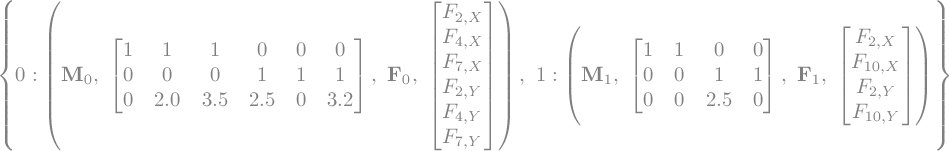

In [15]:
n_round = 6
d_member_forceinfo = {
    member_: (
        M := MatrixSymbol(r"\mathbf{M}"+f"_{member_}",3,len(fvc_),),
        M_ := Matrix([
            [1]*len(fvc_)+[0]*len(fvc_),
            [0]*len(fvc_)+[1]*len(fvc_),
            [np.round(graph.d_node_vertices[keynode_][0],n_round) for keynode_ in keynodes_]
            +[np.round(graph.d_node_vertices[keynode_][1],n_round) for keynode_ in keynodes_]
        ]),
        F := MatrixSymbol(r"\mathbf{F}"+f"_{member_}",len(fvc_),1),
        F_ := Matrix(
            [
                fvxy_["X"]
                for fvxy_ in fvc_
            ] + [
                fvxy_["Y"]
                for fvxy_ in fvc_
            ]
        )
    )
    for ((member_,fvc_),(member_,keynodes_))
    in zip(d_member_fvc.items(),geometry.d_member_keynodes.items())
}
d_member_forceinfo

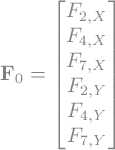

In [16]:
member_ = 0
keynodes_ = geometry.d_member_keynodes[member_]
F = MatrixSymbol(r"\mathbf{F}"+f"_{member_}",6,1)
F_ = Matrix([
    Symbol(rf"F_{keynode_},X", real=True,)
    for keynode_ in keynodes_
] + [
    Symbol(rf"F_{keynode_},Y", real=True,)
    for keynode_ in keynodes_
])
Eq(F,F_)

# Visualization

To view these structures in 3D online, go to:
   - [Simple structure #1](https://htmlpreview.github.io/?https://github.com/cstarkjp/ConceptualDesign/blob/main/Plots/simpleStructure1.html)
   - [Standing tower #1](https://htmlpreview.github.io/?https://github.com/cstarkjp/ConceptualDesign/blob/main/Plots/standingTower1.html)

In [17]:
viz = Visualization(font_name="Arial")

Need to cross-ref applied load triangles to actual graph and pvmesh triangles – if we want to label the load triangles in 3D.

In [18]:
pvmesh = viz.build_mesh(geometry)

In [19]:
plotter = viz.plot_model_3d(
    pvmesh, 
    geometry,
    forces,
    backend="trame", 
    do_appliedload_labels=True,
    font_size=15,
)

Widget(value="<iframe src='http://localhost:54149/index.html?ui=P_0x16d757910_0&reconnect=auto' style='width: …

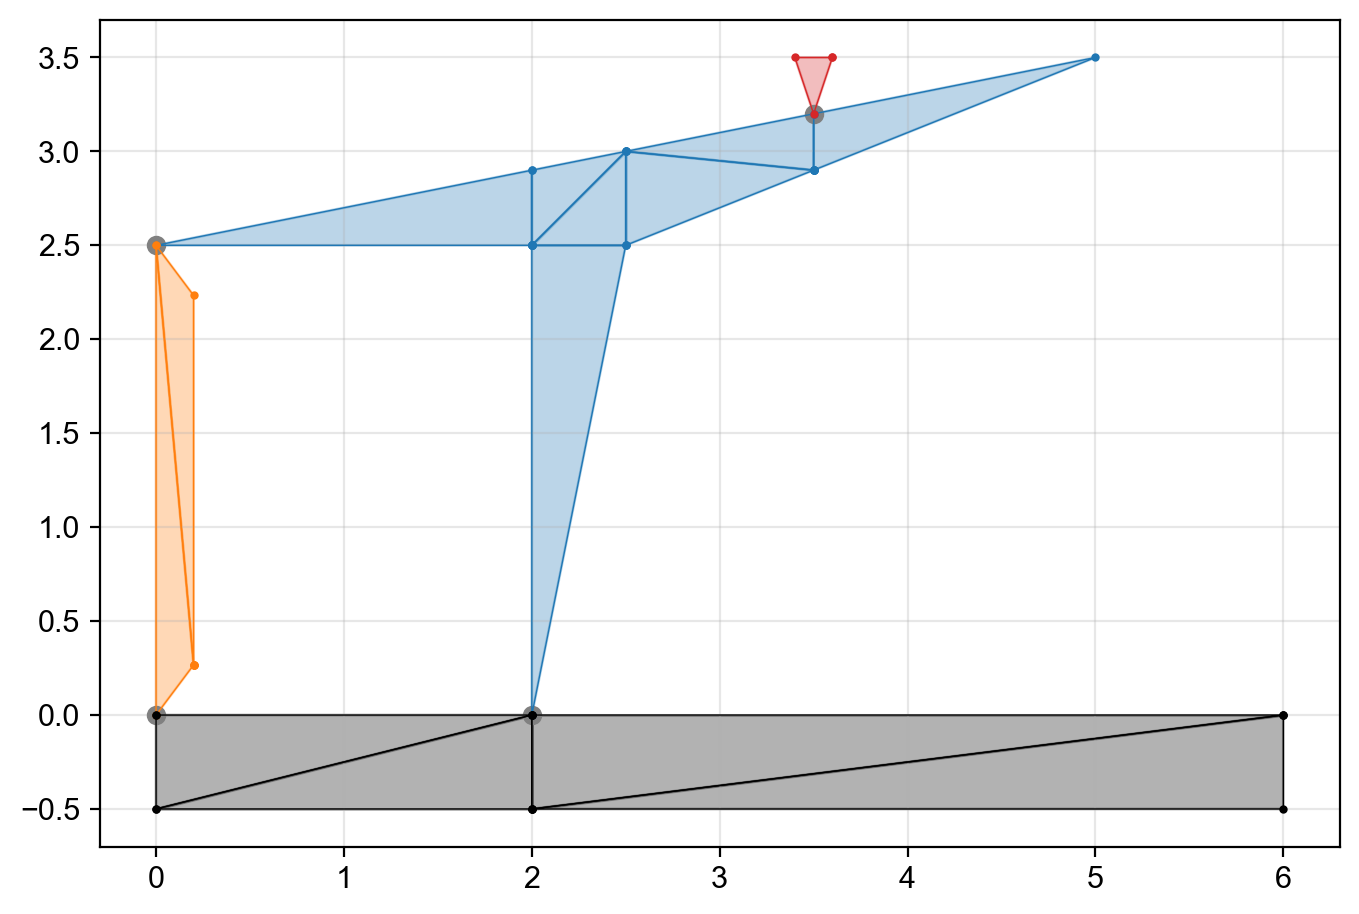

In [20]:
viz.plot_model(name, graph, communities, geometry)

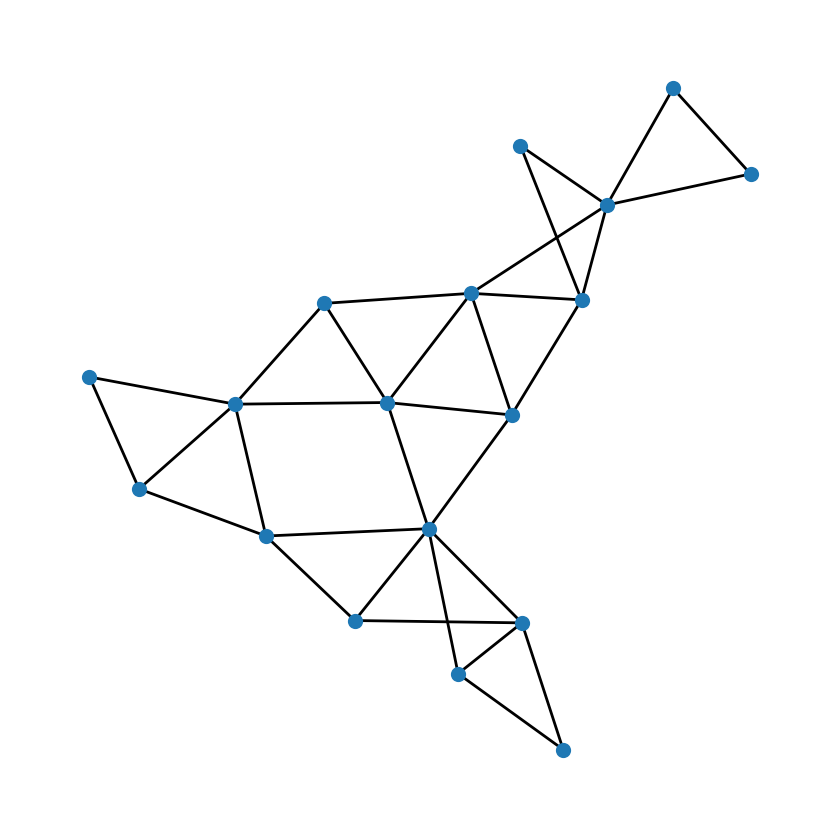

In [21]:
viz.plot_graph(name, graph, fig_size=(4,4,),)

# Export

In [22]:
plots_dirname = "Plots"
plots_path = create_directories(("..",), plots_dirname)
for gr_ in [viz]:    
    export_plots( gr_.fdict, plots_path, file_types=["jpg"], dpi=100 )

In [23]:
plotter.export_html(os.path.join(plots_path, f"{name}.html"))